# Compressed Sensing Simple Example

This notebook is a reworked copy from  
https://gist.github.com/gallamine/9223302  
which in turn is based on   
http://brocabrain.blogspot.com/2012/10/compressed-sensing-with-sklearn-dtmf.html  
which is based on   
https://www.mathworks.com/company/newsletters/articles/magic-reconstruction-compressed-sensing.html

Suppose we have a time signal. This signal is not known, but we do know something about it - namely that it's *sparse* in *some* domain. Maybe that means it's only made up of certain frequencies, so when you look at the signal in the frequency domain it's mostly zeros, with a few non-zero values intermixed. 

Let's call this **unknown** signal $X$. Now, even though we don't know the whole signal, we can still make observations of it, or samples. Sampling could be expensive, time consuming or not technilogically feasible, which is why we want to limit the number of observations or samples to as small a number as possible.

Furthermore, when we make observations of the signal we aren't going to do it in a repeting pattern (*e.g.* every 10th sample). No, instead we're going to **randomly** sample the data.

Let's try this in Python:

In [124]:
%matplotlib inline
from matplotlib.pyplot import plot, show, figure, title
import matplotlib as plt
import numpy as np

from scipy.fftpack import dct, idct
from scipy.sparse import coo_matrix

In [153]:
Fs = 40e3  #Sample rate
duration = 1./8
N_samps = np.floor(duration*Fs)
M = 250   # Number of compressed "basis" functions - we're going from N_samps to M samps.
f1 = 200
f2 = 3950

print "Compression ratio {0}".format(M/N_samps)
t = np.linspace(0,duration,N_samps)

Compression ratio 0.05


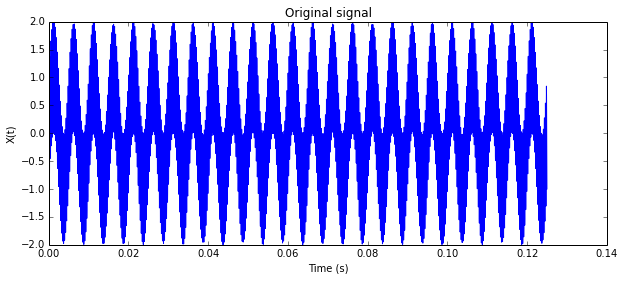

In [154]:
X = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

figure(figsize=[10,4])
plot(t,X)
title('Original signal')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t)')

Now we're going to chose random points in time from which to sample the data. 

In [155]:
yi = np.random.randint(0,N_samps,(M,))
yi = np.sort(yi)
Y = X[yi]

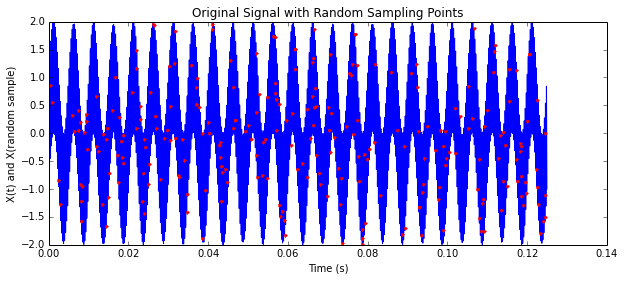

In [156]:
figure(figsize=[10,4])
plot(t,X,'b',t[yi],Y,'r.')
title('Original Signal with Random Sampling Points')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t) and X(random sample)')

Now we know two things, A) we know our samples, $X(t_{samps})$ and we know the sample times, $t_{samps}$. Using this we can transform our samples into the *sparse domain*. In this case, we've chosen the Discrete Cosine Domain. This could just as easily been the Discrete Fourier domain. In fact, you might want to try both just to see the differences.

We're computing the DCT for each of the possible sample points (N_samps) and then only choosing the ones we actually sampled at. $A$ is now the DCT basis functions corresponding to our random sample times *in the time domain*. It is literally a matrix where each column corresponds a cosine function at a different frequency. The frequencies correspond to the sample times we chose randomly. In other words, $A$ now represents what those samples look like in another domain. 

In [157]:
D = dct(np.eye(N_samps))   # Construct the DCT basis functions for each of the frequencies
A = D[yi]                  # Downsample based on our random sampling

In [158]:
np.shape(A)

(250L, 5000L)

This means we now *know* $A$, based on the sample times, and $Y$, which is our sampled data. We also know that the original data, $X$ was sparse in the DCT domain. We'll call the sparse DCT version of $X$, $\tilde X$. *We are now trying to solve for $\tilde X$ based on this knowledge*. In other words we're trying to find the solution to $\tilde X$ that makes the equation $A\tilde X = Y$ true. $A$ is the translation from our random time samples into the DCT domain, $\tilde X$ is in DCT domain and is presumed sparse, and $Y$ is a time domain signal. In other words, we're trying to solve, $\min (Y - A\tilde X)$ in some fashion.

We can use the LASSO to find the sparse solution. It's solving:

$$ c * ||Y - A\tilde X||^2_2 + alpha * ||\tilde X||_1 $$

where $c$ is some constant based on the number of samples, and $||\tilde X||_1 $ is the $\ell_1$ norm, which assures that the solution to $\tilde X$ is sparse.

In [159]:
from sklearn.linear_model import Lasso   # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Solution is %96.22 sparse


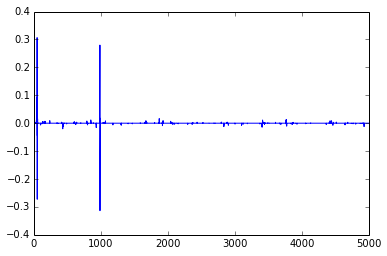

In [160]:
lasso = Lasso(alpha=0.01)
lasso.fit(A,Y)

plot(lasso.coef_)

sparseness = np.sum(lasso.coef_ == 0)/N_samps
print "Solution is %{0} sparse".format(100.*sparseness)

The plot above shows how many DCT coefficients in the final solution are non-zero. Remember, this solution is what we approximate $X$ to be in the DCT domain. You can see that there are very very few coefficients that are not zero. To find out what we estimate the true signal to be in the time domain, $\hat X$, we take the Inverse Discrete Cosine Transform (IDCT) of the LASSO solution.

In [161]:
Xhat = idct(lasso.coef_)

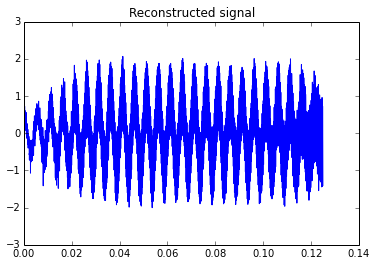

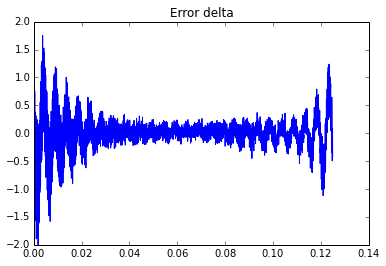

In [162]:
figure()
plot(t,Xhat)
title('Reconstructed signal')
figure()
plot(t,Xhat-X)
title('Error delta')

The plots above show the reconstructed signal in the time domain and the reconstructed signal, $\hat X$ versus the original signal, $X$. You can see how the error tends to go up at the beginning and end of the signal. I presume this is due to the fact that we don't have unlimited data and are taking a window of fixed length.

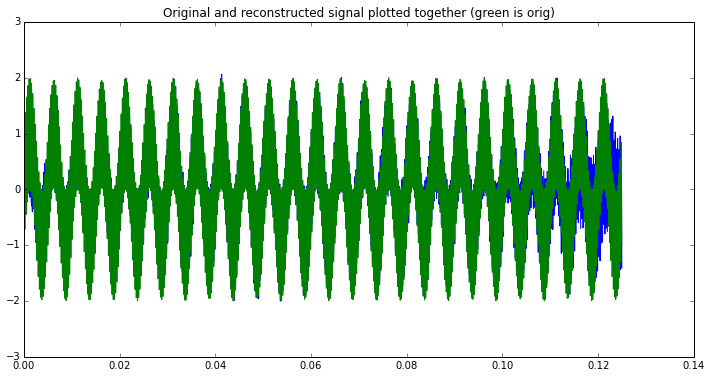

In [165]:
figure(figsize=[12,6])
plot(t,Xhat)
plot(t,X)
title("Original and reconstructed signal plotted together (green is orig)")

Don't forget that this reconstruction is achieved using only a small fraction of the total sample. The compression ratio is:

In [168]:
print "Signal is reconstructed using only %{0} of the data!".format(100.*M/N_samps)

Signal is reconstructed using only %5.0 of the data!


It's a little hard to tell what's going on in the figure above. A better way to look at things would be to look at the signal in the frequency domain where, since that's where it's sparse.

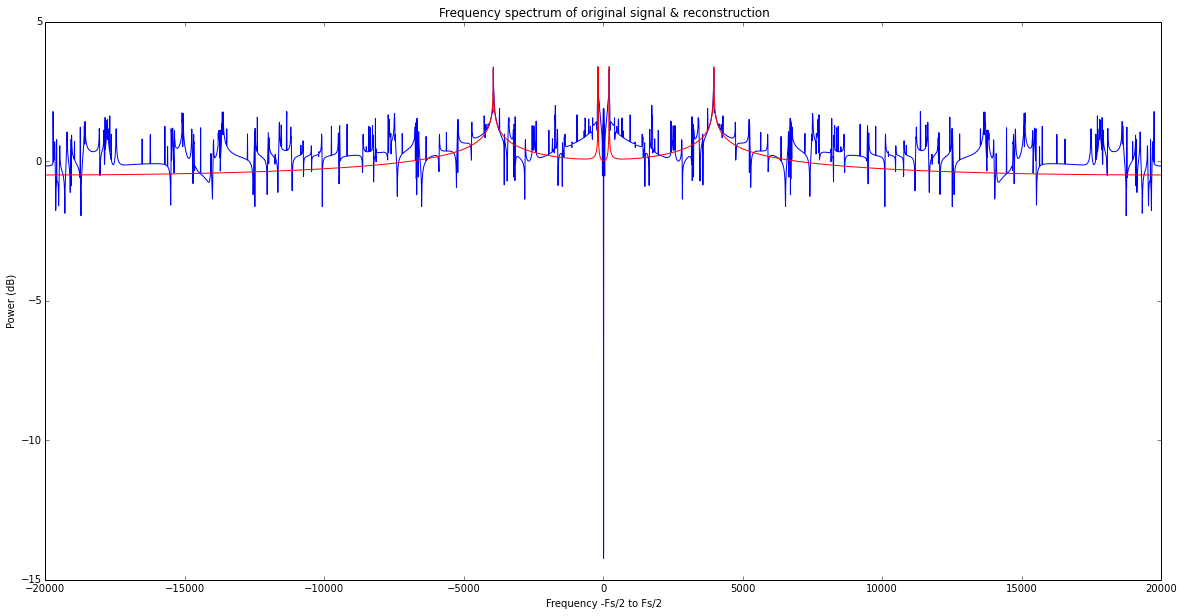

In [171]:
f = np.linspace(-Fs/2,Fs/2,N_samps)
figure(figsize=[20,10])
plot(f,np.log10(np.fft.fftshift(np.abs(fft(Xhat)))))
title("Frequency spectrum of original signal & reconstruction")
plot(f,np.log10(np.fft.fftshift(np.abs(fft(X)))),'r')
plt.pyplot.xlabel('Frequency -Fs/2 to Fs/2')
plt.pyplot.ylabel('Power (dB)')